In [1]:
import os,sys
import numpy as np
import numpy.linalg as LA
import matplotlib
import pylab as py
import math
import pandas as pd
from scipy.integrate import quad,fixed_quad

import matplotlib
# %matplotlib inline
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
# #matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
# matplotlib.rc('text',usetex=True)
import pylab  as py
# from matplotlib.lines import Line2D

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-yy4zfzsz because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


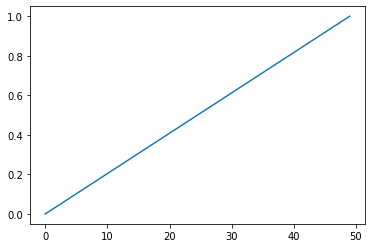

In [2]:
ax=py.subplot(111)
ax.plot(np.linspace(0,1))

In [3]:
sys.path.append('/work/JAM/barryp/JAM/fitpack2/')
os.environ['FITPACK']='/work/JAM/barryp/JAM/fitpack2/'

In [4]:
import copy
from tools.config import conf,load_config
from tools.tools import load,save,checkdir,lprint

In [5]:
from qcdlib import aux,mellin

from fitlib.resman import RESMAN
from obslib.pITD import theory
from obslib.ccLCS import theory
from analysis.corelib import core,summary,inspect

In [6]:
from scipy.special import gamma

# From Fits to ${\it only}$ systematics

In [138]:
pred=load('/work/JAM/barryp/JAM/analysis-LCS/ccLCSnew/onlysys/data/predictions-17.dat')

In [139]:
idx=[]
for i in range(len(pred['order'])):
    if 'lat-sys' in pred['order'][i][1]:
        idx.append(i)

In [140]:
par=[]
i0=0
for i in range(len(pred['res'])):
    order=[]
    L=len(pred['order'])
    par.append([])
    for j in idx:
#         par[i].append(np.abs(pred['params'][i0+j]))
        par[i].append(pred['params'][i0+j])
        order.append(pred['order'][j])
    i0+=L

In [141]:
order

[[1, 'lat-sys', 'b0-ccLCS'],
 [1, 'lat-sys', 'p0-ccLCS'],
 [1, 'lat-sys', 'r0-ccLCS'],
 [1, 'lat-sys', 'm0-ccLCS'],
 [1, 'lat-sys', 'f0-ccLCS'],
 [1, 'lat-sys', 'b1-ccLCS'],
 [1, 'lat-sys', 'p1-ccLCS'],
 [1, 'lat-sys', 'r1-ccLCS'],
 [1, 'lat-sys', 'm1-ccLCS'],
 [1, 'lat-sys', 'f1-ccLCS'],
 [1, 'lat-sys', 'b2-ccLCS'],
 [1, 'lat-sys', 'p2-ccLCS'],
 [1, 'lat-sys', 'r2-ccLCS'],
 [1, 'lat-sys', 'm2-ccLCS'],
 [1, 'lat-sys', 'f2-ccLCS']]

In [142]:
parmean=np.mean(par,axis=0)

In [143]:
cov=np.zeros((len(parmean),len(parmean)))

In [144]:
for i in range(len(parmean)):
    for j in range(len(parmean)):
        for k in range(len(par)):
            cov[i][j]+=(par[k][i]-parmean[i])*(par[k][j]-parmean[j])
cov/=(len(par)-1)

In [145]:
w, v = LA.eig(LA.inv(cov))
v=v.T

In [146]:
w

array([1.58161427e+17, 1.10997717e+16, 1.69346497e+07, 3.58540668e+05,
       1.07515112e+05, 4.91881653e+03, 1.17280792e+03, 8.73944536e+02,
       1.83580452e+02, 5.55131499e+00, 2.74669591e+00, 3.89084277e-01,
       2.98996603e-02, 2.33169657e-02, 1.87847144e-03])

In [147]:
sortorder=[]
for i in range(len(np.sort(w))):
    for j in range(len(w)):
        if np.sort(w)[i]==w[j]: sortorder.append(j)

In [148]:
sortorder=sortorder[::-1]

In [149]:
wsort=w[sortorder]

[]

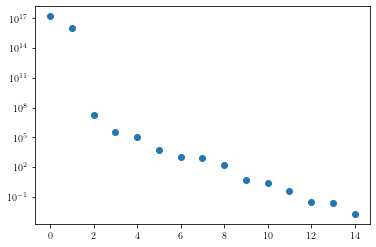

In [150]:
ax=py.subplot(111)
ax.plot(np.sort(w)[::-1],'o')
ax.semilogy()

In [151]:
vsort=v[sortorder]

In [158]:
def predict(wdir,v,parorder,meanpar,data='both'):
    load_config('%s/input.py'%wdir)
    istep=core.get_istep()
    replicas=core.get_replicas(wdir)
    rep=replicas[0]
    repnames=sorted(os.listdir('%s/msr-inspected'%wdir))

    core.mod_conf(istep,replicas[0])
    order=replicas[0]['order'][istep]

    conf['bootstrap']=False
    
    resman=RESMAN(nworkers=10,parallel=True,datasets=True)
    parman=resman.parman
    
    obsres={}
    if 'dy-pion' in conf['datasets']: obsres['dy-pion']=resman.dy_pion_res
    if 'ln' in conf['datasets']: obsres['ln']=resman.ln_res
    if 'ccLCS' in conf['datasets']: obsres['ccLCS']=resman.ccLCS_res
    
    data={}
    data['order']=order
    data['params']=[]
    data['reactions']={}
    data['res']=[]
    data['rres']=[]
    data['nres']=[]
    
    for _ in obsres:
        tabs=copy.copy(obsres[_].tabs)
        for idx in tabs:
            tabs[idx]['prediction-rep']=[]
            tabs[idx]['residuals-rep']=[]
            tabs[idx]['shift-rep']=[]
        data['reactions'][_]=tabs
        print(data['reactions'].keys())
        
        
    rep=replicas[0]
    parman.par=copy.copy(rep['params'][istep])
    parman.order=copy.copy(rep['order'][istep])
    shifts=np.linspace(-1000,1000,100)

    for j in range(len(shifts)):
        for i in range(len(parorder)):
            po=str(parorder[i][2].split('-')[0])
            parshift=v[i]*shifts[j]
            if po=='f0':
                conf['ccLCS'].f0=meanpar[i]+parshift
            elif po=='b0':
                conf['ccLCS'].b0=meanpar[i]+parshift
            elif po=='p0':
                conf['ccLCS'].p0=meanpar[i]+parshift
            elif po=='r0':
                conf['ccLCS'].r0=meanpar[i]+parshift
            elif po=='m0':
                conf['ccLCS'].m0=meanpar[i]+parshift
            elif po=='f1':
                conf['ccLCS'].f1=meanpar[i]+parshift
            elif po=='b1':
                conf['ccLCS'].b1=meanpar[i]+parshift
            elif po=='p1':
                conf['ccLCS'].p1=meanpar[i]+parshift
            elif po=='r1':
                conf['ccLCS'].r1=meanpar[i]+parshift
            elif po=='m1':
                conf['ccLCS'].m1=meanpar[i]+parshift
            elif po=='f2':
                conf['ccLCS'].f1=meanpar[i]+parshift
            elif po=='b2':
                conf['ccLCS'].b2=meanpar[i]+parshift
            elif po=='p2':
                conf['ccLCS'].p2=meanpar[i]+parshift
            elif po=='r2':
                conf['ccLCS'].r2=meanpar[i]+parshift
            elif po=='m2':
                conf['ccLCS'].m2=meanpar[i]+parshift
        lprint('progress: %i/%i'%(j+1,len(shifts)))
        res,rres,nres=resman.get_residuals(parman.par,initial=True)
        data['res'].append(res)
        data['rres'].append(rres)
        data['nres'].append(nres)

        for _ in obsres:
            for idx in data['reactions'][_]:
                prediction=copy.copy(obsres[_].tabs[idx]['prediction'])
                residuals =copy.copy(obsres[_].tabs[idx]['residuals'])
                data['reactions'][_][idx]['prediction-rep'].append(prediction)
                data['reactions'][_][idx]['residuals-rep'].append(residuals)
                data['reactions'][_][idx]['lambda']=shifts
                
    resman.shutdown()
    for _ in ['res','rres','nres']:
        data[_]=np.array(data[_])
    checkdir('%s/data'%wdir)
    save(data,'%s/data/predictions-%d-eigen2.dat'%(wdir,istep))

In [159]:
wdir='/work/JAM/barryp/JAM/analysis-LCS/ccLCS/NLOcconly/'

In [160]:
eigen=vsort[0]#*np.sqrt(w[0])
predict(wdir,eigen,order,parmean)

loading dy-pion data sets 10001
loading dy-pion data sets 10002
loading dy-pion data sets 10003
10001 has norm uncertainty
10002 has norm uncertainty
10003 has norm uncertainty
loading ln data sets 1000
loading ln data sets 2000
1000 has norm uncertainty
2000 has norm uncertainty
loading ccLCS data sets 12781
loading ccLCS data sets 13581
loading ccLCS data sets 14131
loading ccLCS data sets 14132
dict_keys(['dy-pion'])
dict_keys(['dy-pion', 'ln'])
dict_keys(['dy-pion', 'ln', 'ccLCS'])
progress: 100/100

In [161]:
def get_chi2_eigen(predictions,wdir):
    chi2={}
    expt=[]
    for k in predictions['reactions']:
        if k!='ccLCS': continue
        for kk in predictions['reactions'][k]:
            expt.append(kk)
            #--get chi2
            chi2[kk]={}
            chi2[kk]['lambda']=predictions['reactions'][k][kk]['lambda']
            chi2[kk]['chi2']=[]
            chi2[kk]['chi2/npts']=[]
            p=predictions['reactions'][k][kk]
            chi2[kk]['npts']=len(p['value'])
            for i in range(len(p['prediction-rep'])):
                res=(p['value']-p['prediction-rep'][i])/p['alpha']
                chi2[kk]['npts']=len(res)
                chi2[kk]['chi2'].append(np.sum(res**2))
                chi2[kk]['chi2/npts'].append(np.sum(res**2)/len(res))
                
        chi2['chi2 total']={}
        chi2['chi2 total']['chi2']=np.zeros(len(chi2[kk]['chi2/npts']))
        chi2['chi2 total']['npts']=0
        for k in expt:
            for i in range(len(chi2[k]['chi2/npts'])):
                chi2['chi2 total']['chi2'][i]+=chi2[k]['chi2/npts'][i]*chi2[k]['npts']
            chi2['chi2 total']['npts']+=chi2[k]['npts']
            chi2['chi2 total']['lambda']=chi2[kk]['lambda']
    return chi2

In [162]:
def test(pred,wdir):
    chi2fit=get_chi2_eigen(pred,wdir)
    nrows,ncols=1,1
    py.figure(figsize=(8*ncols,6*nrows))
    ax=py.subplot(nrows,ncols,1)
    labs={12781: 'a94m278',13581: 'a94m358', 14131: 'a127m413', 14132: 'a127m413L'}
    for k in chi2fit:
        if k=='chi2 total': #continue
            ax.plot(chi2fit[k]['lambda'],chi2fit[k]['chi2']/chi2fit[k]['npts'],lw=3,c='k',label=r'$\rm total$')
            ax.axhline(y=min(chi2fit[k]['chi2']/chi2fit[k]['npts']),lw=2,ls='--')
        else:
            ax.plot(chi2fit[k]['lambda'],chi2fit[k]['chi2/npts'],lw=3,label=r'$\rm %s$'%labs[k])
            ax.axhline(y=min(chi2fit[k]['chi2/npts']),lw=2,ls='--')

    minchi2=1e10
    minidx=0
    for i in range(len(chi2fit['chi2 total']['chi2'])):
        if chi2fit['chi2 total']['chi2'][i]<minchi2: 
            minchi2=chi2fit['chi2 total']['chi2'][i]
            minidx=i

    ax.axvline(x=chi2fit[12781]['lambda'][minidx],ls=':',label=r'${\rm best~fit}$')
    ax.tick_params(direction='in',which='both',labelsize=20)
    ax.set_ylabel(r'$\chi^2_{\rm npts}$',size=30)
    ax.set_xlabel(r'$\lambda$',size=30)
    
    ax.legend(fontsize=20)
    py.tight_layout()
    checkdir('new_gallery/chi2params/nosys')
    py.savefig('new_gallery/chi2params/nosys/eigen-vsort0.png')
    

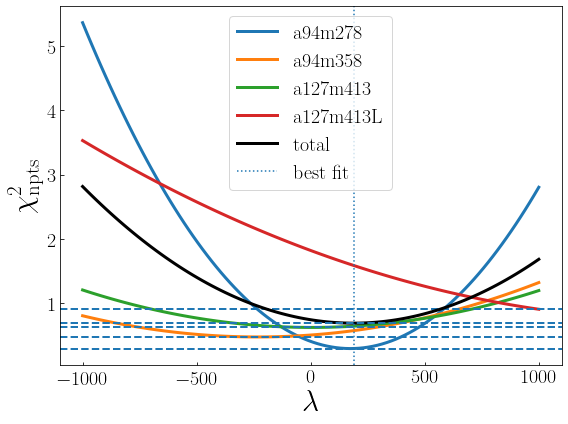

In [163]:
p=load('%s/data/predictions-17-eigen2.dat'%wdir)
test(p,w)